# Twitter sentiment
-[Rishit Dagli](rishit.tech)

## About Me

[Twitter](https://twitter.com/rishit_dagli)

[GitHub](https://github.com/Rishit-dagli)

[Medium](https://medium.com/@rishit.dagli)

## Some imports

In [78]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
import sklearn
import tensorflow as tf
import seaborn as sns

## Load the data

In [64]:
train_df = pd.read_csv('Twitter/train.csv')
test_df = pd.read_csv('Twitter/test.csv')

## Preprocessing

Let's make a pairplot

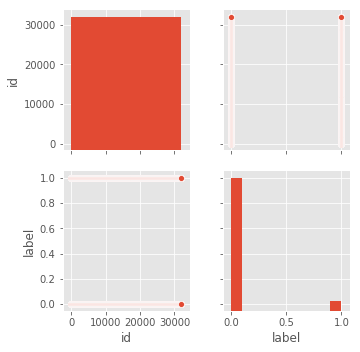

In [79]:
sns.pairplot(train_df)

First we will seperate our data in xs and ys

In [65]:
x_train = train_df['tweet']
y_train = train_df['label']
x_test = test_df['tweet']

If you observe the dataset it has some characters like `@` and `#`., we first need to remove them

In [66]:
def clean_up(text):
    text = re.sub('\d+','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

total_data = x_train.append(x_test)
total_data = total_data.apply(clean_up)

Let's see the number of labels we have

In [67]:
print(train_df.groupby('label')['label'].count())
print('The shape of train is {}'.format(x_train.shape))
print('The shape of holdout test is {}'.format(x_test.shape))

label
0    29720
1     2242
Name: label, dtype: int64
The shape of train is (31962,)
The shape of holdout test is (17197,)


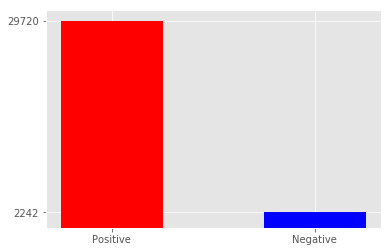

In [75]:
xs = (0, 1)
ys = (29720, 2242)
labels =("Positive", "Negative")

plt.style.use('ggplot')
fig = plt.figure()                                                               
ax = fig.gca()
ax.bar(xs, ys, 0.5, align='center', color = ['red', 'blue'])
ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.set_yticks(ys)

## Tokenize

Now we will tokenize our sentences

In [68]:
max_fatures = 2000
word_ind = dict()
def tokenize(text_frame):
    tokenizer = Tokenizer(num_words=max_fatures, split=' ')
    tokenizer.fit_on_texts(text_frame.values)
    tokenized = tokenizer.texts_to_sequences(text_frame.values)
    padded_seq = pad_sequences(tokenized)
    word_ind = tokenizer.word_index
    return padded_seq

In [69]:
total_data = tokenize(total_data)
x_train = total_data[:x_train.shape[0]]
holdout_test = total_data[x_train.shape[0]:]
print(train_df.groupby('label')['label'].count())
print('The shape of train is {}'.format(x_train.shape))
print('The shape of holdout test is {}'.format(x_test.shape))

label
0    29720
1     2242
Name: label, dtype: int64
The shape of train is (31962, 31)
The shape of holdout test is (17197,)


## Model

In [29]:
embed_dim = 128

model = Sequential([
    Embedding(max_fatures, embed_dim,input_length = x_train.shape[1]),
    #SpatialDropout1D(0.4),
    tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(256,activation='relu'),
    Dense(64,activation='relu'),    
    Dense(1,activation='sigmoid')])

In [30]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 31, 128)           256000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 404,353
Trainable params: 404,353
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size = 0.2, random_state = 42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(13091, 31) (13091,)
(3273, 31) (3273,)


In [35]:
history = model.fit(x_train, y_train, epochs = 8, verbose = 1,
         validation_data = (x_test,y_test))

Train on 13091 samples, validate on 3273 samples
Epoch 1/8
13091/13091 [==============================] - 60s 5ms/sample - loss: 0.0323 - accuracy: 0.9872 - val_loss: 0.3345 - val_accuracy: 0.9383
Epoch 2/8
13091/13091 [==============================] - 52s 4ms/sample - loss: 0.0255 - accuracy: 0.9899 - val_loss: 0.3502 - val_accuracy: 0.9340
Epoch 3/8
13091/13091 [==============================] - 50s 4ms/sample - loss: 0.0208 - accuracy: 0.9928 - val_loss: 0.3945 - val_accuracy: 0.9395
Epoch 4/8
13091/13091 [==============================] - 50s 4ms/sample - loss: 0.0208 - accuracy: 0.9924 - val_loss: 0.4098 - val_accuracy: 0.9429
Epoch 5/8
13091/13091 [==============================] - 50s 4ms/sample - loss: 0.0174 - accuracy: 0.9933 - val_loss: 0.4771 - val_accuracy: 0.9355
Epoch 6/8
13091/13091 [==============================] - 50s 4ms/sample - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.4181 - val_accuracy: 0.9419
Epoch 7/8
13091/13091 [==============================] - 51s 4m

## Few graphs

Let's now create some training graphs

In [36]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

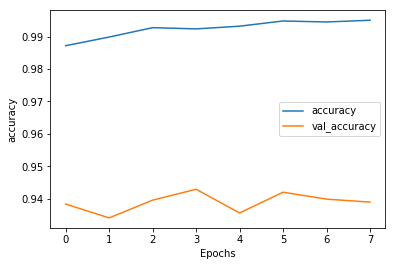

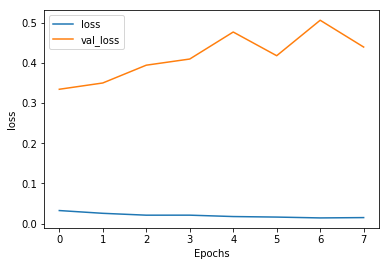

In [37]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [38]:
preds = model.predict(x_test)

Accuracy: 0.9389
F1 score: 0.505
AUC-ROC: 0.7319
The confusion matrix for the model is
[[2971   96]
 [ 104  102]]


Text(0, 0.5, 'TPR')

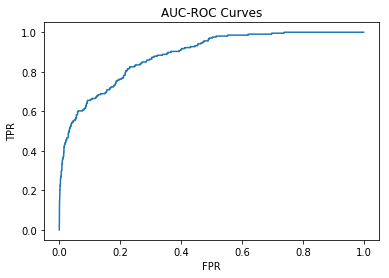

In [41]:
fpr, tpr, thresh = roc_curve(y_test, preds)

#print('The metrics for the {} model is as below:'.format(name))
print('Accuracy: {}'.format(round(accuracy_score(y_test, preds.round()),4)))
print('F1 score: {}'.format(round(f1_score(y_test, preds.round()),4)))
print('AUC-ROC: {}'.format(round(roc_auc_score(y_test, preds.round()),4)))
print('The confusion matrix for the model is')
print(confusion_matrix(y_test,preds.round()))

plt.plot(fpr, tpr)
plt.title('AUC-ROC Curves')
plt.xlabel('FPR')
plt.ylabel('TPR')

## Conclusion

We did a pretty good job, we did not overfit at all and got a pretty good accuracy too!